In [27]:
from dotenv import load_dotenv
load_dotenv()

True

In [28]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: List
    answer: str

In [29]:
from langchain_community.tools import TavilySearchResults

tavily_search_tool = TavilySearchResults(
    max_results=3,
    search_engine="advanced",
    include_answers=True,
    include_raw_content=True,
    include_images=True,
)

In [30]:
def web_search(state: AgentState) -> AgentState:
    """ 
    주어진 state를 기반으로 웹 검색을 수행합니다.
    
    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.
        
    Returns:
        AgentState: 웹 검색 결과가 추가된 state를 반환합니다.    
    """
    query = state["query"]
    results = tavily_search_tool.invoke(query)
    
    return {'context': results}

In [31]:
from langchain import hub
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

generate_prompt = hub.pull('rlm/rag-prompt')
generate_llm = ChatOpenAI(model='gpt-4o')

def web_generate(state: AgentState) -> AgentState:
    """
    주어진 문맥과 질문을 기반으로 답변을 생성합니다.
    Args:
        state (AgentState): 문맥과 질문을 포함한 에이전트의 현재 state.
        
    Returns:
        AgentState: 생성된 답변을 포함한 state를 반환합니다.      
    """
    context = state['context']
    query = state['query']
    
    rag_chain = generate_prompt | generate_llm | StrOutputParser()
    response = rag_chain.invoke({"context": context, "question": query})
    
    return {'answer': response}

c:\workspace\uv_work\.venv\Lib\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [32]:
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

basic_llm = ChatOpenAI(model='gpt-4o-mini')

def basic_generate(state: AgentState) -> AgentState:
    """
    사용자의 질문에 기반하여 기본 답변을 생성합니다.
    
    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.
        
    Returns:
        AgentState: 생성된 답변을 포함한 state를 반환합니다.      
    """
    query = state['query']
    
    llm_response = basic_llm.invoke(query)
    
    return {'answer': llm_response}

In [33]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from typing import Literal

class Route(BaseModel):
    target: Literal['vector_store','llm','web_search'] = Field(
        description="The target for the query  to answer"
    )

router_system_prompt = """
You are an expert at routing a user's question to 'vector_store', 'llm', or 'web_search'.
'vector_store' contains information about income tax up to December 2024.
if you think the question is simple enough use 'llm'
if you think you need to search the web to answer the question use 'web_search'
"""

router_prompt = ChatPromptTemplate.from_messages(
    [
        ('system', router_system_prompt),
        ('human', "{query}")
    ]
)

router_llm = ChatOpenAI(model="gpt-4o-mini")
structed_router_llm = router_llm.with_structured_output(Route)

def router(state: AgentState) -> Literal['vector_store', 'llm', 'web_search']:
    """
    사용자의 질문을 기반으로 적절한 경로를 결정합니다.
    
    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.
        
    Returns:
        Literal['vector_store', 'llm', 'web_search']: 
        질문을 처리하기 위한 적절한 경로를 나타내는 문자열을 반환한다.      
    """
    query = state['query']
    
    router_chain = router_prompt | structed_router_llm
    
    route = router_chain.invoke({"query": query})
    
    print('route: ', route.target)

    return route.target

In [34]:
from income_tax_agent import graph as income_tax_subgraph

graph_builder = StateGraph(AgentState)

graph_builder.add_node("income_tax_agent", income_tax_subgraph)
graph_builder.add_node("web_search", web_search)
graph_builder.add_node("web_generate", web_generate)
graph_builder.add_node("basic_generate", basic_generate)

In [35]:
from langgraph.graph import START, END

graph_builder.add_conditional_edges(
    START,
    router,
    {
        "vector_store": "income_tax_agent",
        "llm": "basic_generate",
        "web_search": "web_search"
    }
)

graph_builder.add_edge('web_search', 'web_generate')
graph_builder.add_edge('basic_generate',END)
graph_builder.add_edge('web_generate', END)
graph_builder.add_edge('income_tax_agent', END)

In [36]:
graph = graph_builder.compile()

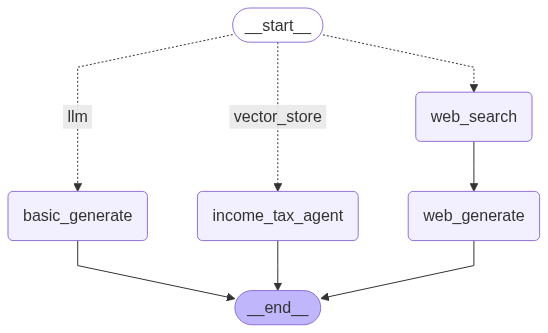

In [37]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

### test 여러버전

In [38]:
# normal 질문
initial_state = {'query': '대한민국 수도는 어디인가요?'}
graph.invoke(initial_state)

route:  llm


{'query': '대한민국 수도는 어디인가요?',
 'answer': AIMessage(content='대한민국의 수도는 서울입니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 15, 'total_tokens': 23, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_e665f7564b', 'finish_reason': 'stop', 'logprobs': None}, id='run--8b3e7100-41ff-4ae0-8bf4-3aee19d04ee3-0', usage_metadata={'input_tokens': 15, 'output_tokens': 8, 'total_tokens': 23, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}

In [41]:
initial_state = {'query': '문화정당역 맛집을 추천해 주세요?'}
graph.invoke(initial_state)

route:  web_search


{'query': '문화정당역 맛집을 추천해 주세요?',
 'context': "HTTPError('401 Client Error: Unauthorized for url: https://api.tavily.com/search')",
 'answer': '죄송하지만, 현재 문화정당역의 맛집 정보를 제공할 수 없습니다.'}

In [42]:
initial_state = {'query': '연봉 5천만원 거주자의 소득세는 얼마인가요?'}
graph.invoke(initial_state)

route:  vector_store
거짓말:  hallucinated
거짓말:  hallucinated
거짓말:  not hallucinated
유용성: helpful


{'query': '연봉 5천만원 거주자의 소득세는 얼마인가요?',
 'context': [Document(metadata={'source': './tax.docx'}, page_content='제55조(세율) ①거주자의 종합소득에 대한 소득세는 해당 연도의 종합소득과세표준에 다음의 세율을 적용하여 계산한 금액(이하 “종합소득산출세액”이라 한다)을 그 세액으로 한다. <개정 2014. 1. 1., 2016. 12. 20., 2017. 12. 19., 2020. 12. 29., 2022. 12. 31.>\n\n| 종합소득 과세표준          | 세율                                         |\n\n|-------------------|--------------------------------------------|\n\n| 1,400만원 이하     | 과세표준의 6퍼센트                             |\n\n| 1,400만원 초과     5,000만원 이하     | 84만원 + (1,400만원을 초과하는 금액의 15퍼센트)  |\n\n| 5,000만원 초과   8,800만원 이하     | 624만원 + (5,000만원을 초과하는 금액의 24퍼센트) |\n\n| 8,800만원 초과 1억5천만원 이하    | 3,706만원 + (8,800만원을 초과하는 금액의 35퍼센트)|\n\n| 1억5천만원 초과 3억원 이하         | 3,706만원 + (1억5천만원을 초과하는 금액의 38퍼센트)|\n\n| 3억원 초과    5억원 이하         | 9,406만원 + (3억원을 초과하는 금액의 38퍼센트)   |\n\n| 5억원 초과      10억원 이하        | 1억 7,406만원 + (5억원을 초과하는 금액의 42퍼센트)|\n\n| 10억원 초과        | 3억 8,406만원 + (10억원을 초과하는 금액의 45퍼센트)|\n\n\n\n\n\n② 거주자의 퇴직소득에 대한 소득세는 다음 